### Mount Google Drive with Colab

In [2]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

### Import the required Libraries

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.preprocessing.image import load_img, img_to_array

### Import | View | Pre-Processing DATASET

In [6]:
# Data Augmentation 
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=30,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [7]:
# Dataset Training
train_dataset  = train_datagen.flow_from_directory(directory = r'C:\Users\Jeath\Downloads\Alzheimer-Disease-Diagnosis-main\Alzheimer-Disease-Diagnosis-main\Alzheimer_Dataset\train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 128)

Found 4098 images belonging to 4 classes.


In [8]:
# Data Validation
valid_dataset = valid_datagen.flow_from_directory(directory = r'C:\Users\Jeath\Downloads\Alzheimer-Disease-Diagnosis-main\Alzheimer-Disease-Diagnosis-main\Alzheimer_Dataset\train',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 128)

Found 1023 images belonging to 4 classes.


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:19<00:00,  3.84s/it]


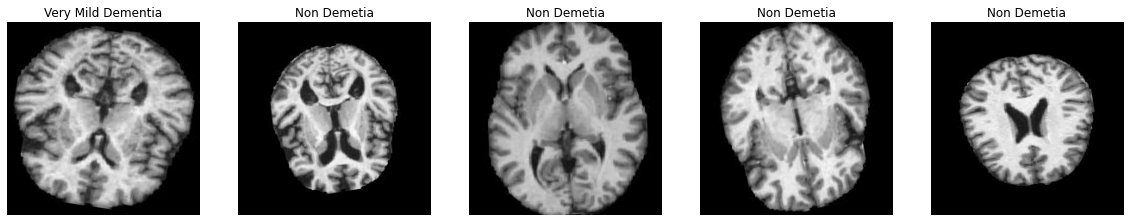

In [9]:
# Images views from different classes 
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize=(20,20))

for i in tqdm(range(0,5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(100)
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    a = train_dataset[rand1][1][rand2]
    if a[0] == 1:
        ax[i].set_title('Mild Dementia')
    elif a[1] == 1:
        ax[i].set_title('Moderate Dementia')
    elif a[2] == 1:
        ax[i].set_title('Non Demetia')
    elif a[3] == 1:
        ax[i].set_title('Very Mild Dementia')

### Build the Model

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import to_categorical
from keras import optimizers

from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

#import tensorflow_addons as tfa
#from tensorflow.keras.metrics import Metric
#from tensorflow_addons.utils.types import AcceptableDTypes, FloatTensorLike
from typeguard import typechecked
from typing import Optional

In [11]:
# Model Initialization

base_model = ResNet50(input_shape=(224,224,3), 
                         include_top=False,
                         weights="imagenet")

In [12]:
# Freezing Layers

for layer in base_model.layers:
    layer.trainable=False

In [13]:
# Building Model and adjust the required parameters

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

In [14]:
# Model Summary

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 100352)            401408    
_________________________________________________________________
dense (Dense)                (None, 2048)              205522944 
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
activation (Activation)      (None, 2048)              0

In [15]:
# Model Compile 

OPT    = tensorflow.keras.optimizers.Adam(lr=0.001)

model.compile(loss='categorical_crossentropy',
              metrics=[tensorflow.keras.metrics.AUC(name = 'auc')],
              optimizer=OPT)

c:\python36\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [16]:
# Defining Callbacks

filepath = './best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [20]:
# Training the model using number of epochs
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 1, # Number of epochs can be changed  
                        callbacks = callback_list,
                        verbose = 1)

33/33 [==============================] - 516s 16s/step - loss: 1.2512 - auc: 0.7773 - val_loss: 1.0808 - val_auc: 0.8090

Epoch 00001: val_auc improved from 0.77528 to 0.80895, saving model to .\best_weights.hdf5


### MODEL EVALUATION

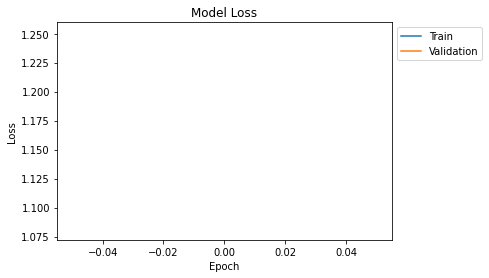

In [21]:
# Summarize history for loss function

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

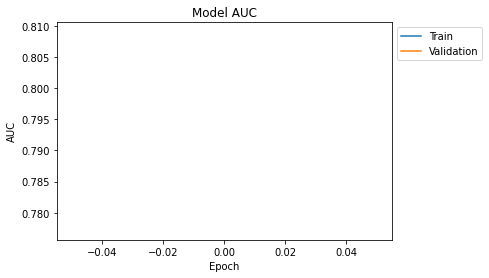

In [22]:
# Summarize history for loss and value accuracy

plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [23]:
# Test Model using the Test Dataset

test_dataset  = test_datagen.flow_from_directory(directory = r'C:\Users\Jeath\Downloads\Alzheimer-Disease-Diagnosis-main\Alzheimer-Disease-Diagnosis-main\Alzheimer_Dataset\test',
                                                 target_size = (224,224),
                                                 class_mode = 'categorical',
                                                 batch_size = 128)

Found 1279 images belonging to 4 classes.


In [24]:
# Evaluating Loss and AUC

model.evaluate(test_dataset)

10/10 [==============================] - 91s 9s/step - loss: 1.1231 - auc: 0.7804


[1.1231095790863037, 0.780361533164978]

55.45 % chances are there that the image is Non-Dementia


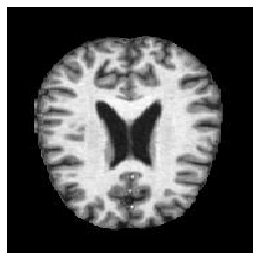

In [25]:
# Test Case No.1: Non-Dementia

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img(r'C:\Users\Jeath\Downloads\Alzheimer-Disease-Diagnosis-main\Alzheimer-Disease-Diagnosis-main\Alzheimer_Dataset\test\NonDemented\26 (100).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
#answer = model.predict_classes(img)
answer = (model.predict(img) > 0.5).astype("int32")
#probability = round(np.max(model.predict_proba(img)*100),2)

probability = round(np.max(model.predict(img)*100),2)

#predict_classes=np.argmax(predict_prob,axis=1)

print(probability, '% chances are there that the image is Non-Dementia')


49.92 % chances are there that the image is Mild Demented


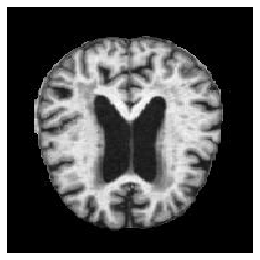

In [26]:
# Test Case 2: Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img(r'C:\Users\Jeath\Downloads\Alzheimer-Disease-Diagnosis-main\Alzheimer-Disease-Diagnosis-main\Alzheimer_Dataset\test/MildDemented/26 (20).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
#answer = model.predict_classes(img)
answer = (model.predict(img) > 0.5).astype("int32")
#probability = round(np.max(model.predict_proba(img)*100),2)

probability = round(np.max(model.predict(img)*100),2)

#predict_classes=np.argmax(predict_prob,axis=1)

print(probability, '% chances are there that the image is Mild Demented')

72.74 % chances are there that the image is Moderate Demented


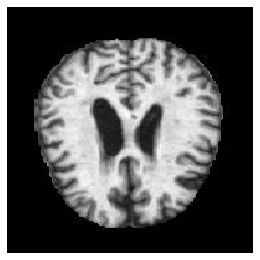

In [27]:
# Test Case 3: Moderate Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img(r'C:\Users\Jeath\Downloads\Alzheimer-Disease-Diagnosis-main\Alzheimer-Disease-Diagnosis-main\Alzheimer_Dataset\test\ModerateDemented\29.jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
#answer = model.predict_classes(img)
answer = (model.predict(img) > 0.5).astype("int32")
#probability = round(np.max(model.predict_proba(img)*100),2)

probability = round(np.max(model.predict(img)*100),2)

#predict_classes=np.argmax(predict_prob,axis=1)

print(probability, '% chances are there that the image is Moderate Demented')

47.62 % chances are there that the image is Moderate Demented


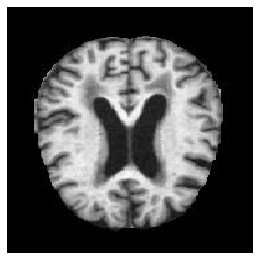

In [28]:
# Test Case 4: Very Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img(r'C:\Users\Jeath\Downloads\Alzheimer-Disease-Diagnosis-main\Alzheimer-Disease-Diagnosis-main\Alzheimer_Dataset\test/MildDemented/26 (22).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
#answer = model.predict_classes(img)
answer = (model.predict(img) > 0.5).astype("int32")
#probability = round(np.max(model.predict_proba(img)*100),2)

probability = round(np.max(model.predict(img)*100),2)

#predict_classes=np.argmax(predict_prob,axis=1)

print(probability, '% chances are there that the image is Moderate Demented')